In [3]:
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [4]:
import pandas as pd

In [5]:
df = pd.read_csv('dataset.csv')
df.head()


,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


In [6]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18368 entries, 0 to 18367
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      18368 non-null  int64  
 1   SystemCodeNumber        18368 non-null  object 
 2   Capacity                18368 non-null  int64  
 3   Latitude                18368 non-null  float64
 4   Longitude               18368 non-null  float64
 5   Occupancy               18368 non-null  int64  
 6   VehicleType             18368 non-null  object 
 7   TrafficConditionNearby  18368 non-null  object 
 8   QueueLength             18368 non-null  int64  
 9   IsSpecialDay            18368 non-null  int64  
 10  LastUpdatedDate         18368 non-null  object 
 11  LastUpdatedTime         18368 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 1.7+ MB


,0
ID,0
SystemCodeNumber,0
Capacity,0
Latitude,0
Longitude,0
Occupancy,0
VehicleType,0
TrafficConditionNearby,0
QueueLength,0
IsSpecialDay,0


In [9]:
!pip install haversine

In [16]:
# Rename columns
df.rename(columns={
    'Latitude': 'lat',
    'Longitude': 'lon',
    'Capacity': 'capacity',
    'Occupancy': 'occupancy',
    'QueueLength': 'queue',
    'Traffic': 'traffic',
    'SpecialDay': 'special_day',
    'VehicleType': 'vehicle',
    'Timestamp': 'timestamp',
    'ParkingLotID': 'lot_id'
}, inplace=True)


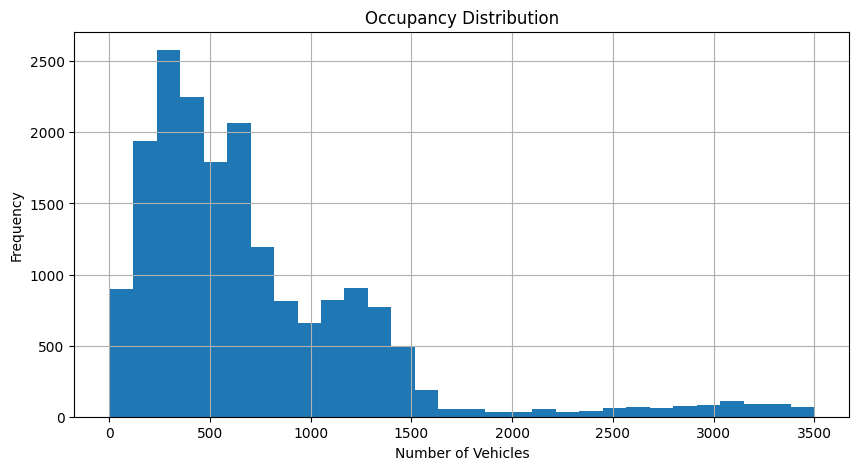

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 5))
df['occupancy'].hist(bins=30)
plt.title("Occupancy Distribution")
plt.xlabel("Number of Vehicles")
plt.ylabel("Frequency")
plt.show()


In [19]:
print("Unique vehicle types:", df['vehicle'].unique())


Unique vehicle types: ['car' 'bike' 'truck' 'cycle']


In [23]:
df.head()

,ID,SystemCodeNumber,capacity,lat,lon,occupancy,vehicle,TrafficConditionNearby,queue,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


In [24]:
print("Unique lots:", df['SystemCodeNumber'].nunique())
print("Special days present:", df['IsSpecialDay'].unique())

Unique lots: 14
Special days present: [0 1]


In [26]:
df['timestamp'] = pd.to_datetime(df['LastUpdatedTime'])

# Extract hour or time block
df['hour'] = df['timestamp'].dt.hour + df['timestamp'].dt.minute / 60


In [27]:
vehicle_weights = {'car': 1.0, 'bike': 0.5, 'truck': 1.5}
df['vehicle_weight'] = df['vehicle'].map(vehicle_weights)


In [28]:
# Model 1
def linear_price_model(prev_price, occupancy, capacity, alpha=2.0):
    return prev_price + alpha * (occupancy / capacity)


In [29]:
# Choose one parking lot (example: lot_id = 1)
lot_id = df['SystemCodeNumber'].unique()[0]
lot_df = df[df['SystemCodeNumber'] == lot_id].sort_values(by='timestamp')

# Initialize price and list
base_price = 10
alpha = 2.0
prices = [base_price]

# Simulate prices for each time step
for i in range(1, len(lot_df)):
    prev_price = prices[-1]
    occ = lot_df.iloc[i]['occupancy']
    cap = lot_df.iloc[i]['capacity']
    new_price = linear_price_model(prev_price, occ, cap, alpha)
    prices.append(round(new_price, 2))

# Assign price back to dataframe
lot_df = lot_df.copy()
lot_df['linear_price'] = prices


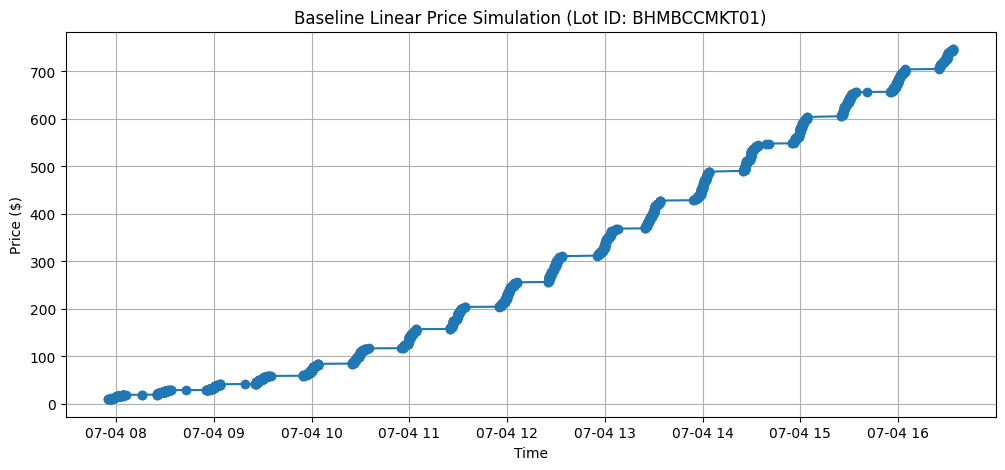

In [30]:
plt.figure(figsize=(12, 5))
plt.plot(lot_df['timestamp'], lot_df['linear_price'], marker='o')
plt.title(f"Baseline Linear Price Simulation (Lot ID: {lot_id})")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.grid(True)
plt.show()


In [34]:
def apply_linear_model_to_all_lots(df, alpha=2.0, base_price=10):
    df = df.sort_values(by=['SystemCodeNumber', 'timestamp'])
    df['linear_price'] = np.nan

    for lot in df['SystemCodeNumber'].unique():
        lot_df = df[df['SystemCodeNumber'] == lot].copy()
        prices = [base_price]
        for i in range(1, len(lot_df)):
            prev_price = prices[-1]
            occ = lot_df.iloc[i]['occupancy']
            cap = lot_df.iloc[i]['capacity']
            price = linear_price_model(prev_price, occ, cap, alpha)
            prices.append(round(price, 2))
        df.loc[lot_df.index, 'linear_price'] = prices

    return df

# Apply to entire dataset
df = apply_linear_model_to_all_lots(df)


In [35]:
# Model 2
vehicle_weights = {'car': 1.0, 'bike': 0.5, 'truck': 1.5}
df['vehicle_weight'] = df['vehicle'].map(vehicle_weights)


In [41]:
def compute_demand(row, alpha=1.0, beta=0.5, gamma=0.3, delta=1.0, epsilon=0.8):
    occ_ratio = row['occupancy'] / row['capacity']
    return (
        alpha * occ_ratio +
        beta * row['queue'] -
        gamma * row['TrafficConditionNearby'] +
        delta * row['IsSpecialDay'] +
        epsilon * row['vehicle_weight']
    )

In [37]:
def demand_based_price(base_price, demand, lambd=0.2):
    # Normalize using sigmoid (bounded between 0 and 1)
    norm_demand = 1 / (1 + np.exp(-demand))
    price = base_price * (1 + lambd * norm_demand)

    # Clamp to [0.5×base, 2×base]
    price = max(min(price, 2 * base_price), 0.5 * base_price)
    return round(price, 2)


In [46]:
def compute_demand(row, alpha=1.0, beta=0.5, gamma=0.3, delta=1.0, epsilon=0.8):
    try:
        occ_ratio = row['occupancy'] / row['capacity']
        return (
            alpha * occ_ratio +
            beta * row['queue'] -
            gamma * row['traffic'] +
            delta * row['special_day'] +
            epsilon * row['vehicle_weight']
        )
    except KeyError as e:
        print(f"Missing column in row: {e}")
        print(row)
        return 0  # fallback value


In [47]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):
    # Earth radius in kilometers
    R = 6371.0

    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))

    return R * c


In [82]:
def get_nearby_lots(df, current_lot_id, radius_km=0.5):
    lot_info = df[df['SystemCodeNumber'] == current_lot_id].iloc[0]
    lat1, lon1 = lot_info['lat'], lot_info['lon']

    nearby_lots = []
    for lot_id in df['SystemCodeNumber'].unique():
        if lot_id == current_lot_id:
            continue
        other = df[df['SystemCodeNumber'] == lot_id].iloc[0]
        lat2, lon2 = other['lat'], other['lon']
        distance = haversine(lat1, lon1, lat2, lon2)
        if distance <= radius_km:
            nearby_lots.append(lot_id)
    return nearby_lots

In [49]:
def competitive_price_adjustment(my_price, nearby_prices):
    if not nearby_prices:
        return my_price

    avg_nearby = np.mean(nearby_prices)

    # If average nearby is lower, reduce price slightly
    if avg_nearby < my_price:
        adjusted = my_price - 0.1 * (my_price - avg_nearby)
    else:
        # If others are more expensive, increase price slightly
        adjusted = my_price + 0.05 * (avg_nearby - my_price)

    return round(max(0.5 * 10, min(adjusted, 2 * 10)), 2)


In [53]:
def apply_demand_based_model_to_all_lots(df, base_price=10, lambd=0.2):
    df = df.copy()
    demands = []
    demand_prices = []

    for index, row in df.iterrows():
        demand = compute_demand(row)
        price = demand_based_price(base_price, demand, lambd)
        demands.append(round(demand, 2))
        demand_prices.append(price)

    df['demand'] = demands
    df['demand_price'] = demand_prices
    return df

# Apply to entire dataset
df = apply_demand_based_model_to_all_lots(df)

Streaming output truncated to the last 5000 lines.
lat                                 26.150504
lon                                 91.733531
occupancy                                1244
vehicle                                   car
TrafficConditionNearby                   high
queue                                       7
IsSpecialDay                                0
LastUpdatedDate                    10-10-2016
LastUpdatedTime                      14:57:00
timestamp                 2025-07-04 14:57:00
hour                                    14.95
vehicle_weight                            1.0
linear_price                          1149.93
Name: 17178, dtype: object
Missing column in row: 'traffic'
ID                                      17304
SystemCodeNumber                     Shopping
capacity                                 1920
lat                                 26.150504
lon                                 91.733531
occupancy                                1242
vehicle        

KeyError: 'comp_price'

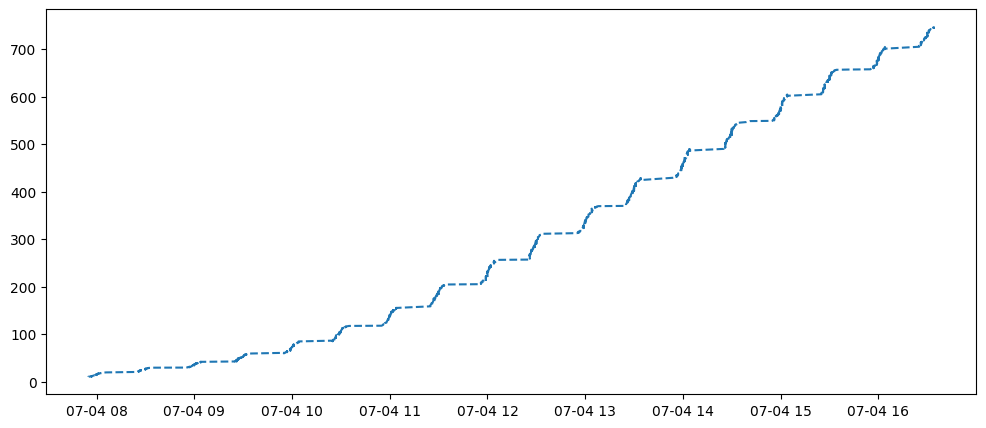

In [55]:
plt.figure(figsize=(12, 5))
plt.plot(lot_df['timestamp'], lot_df['linear_price'], label='Linear Price', linestyle='--')

plt.plot(lot_df['timestamp'], lot_df['comp_price'], label='Competitive Price', linestyle='-.')
plt.title(f"Pricing Comparison (Lot ID: {lot_id})")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()


In [56]:
!pip install pathway --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.6/777.6 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.6/244.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.4/318.4 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.8/985.8 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [57]:
import pathway as pw


In [64]:
from datetime import date
class ParkingLotData(pw.Schema):
    lot_id: int
    occupancy: int
    capacity: int
    queue: int
    traffic: float
    special_day: int
    vehicle: str
    lat: float
    lon: float


In [65]:
table = pw.io.csv.read(
    "/path/to/dataset.csv",  # You can also simulate with chunks or a generator
    schema=ParkingLotData,
    mode="streaming",  # or "static" for testing
    autocommit_duration_ms=500,  # simulate half-second delay

)


In [66]:
@pw.udf
def compute_demand_ratio(occupancy, capacity, queue, traffic, special_day, vehicle):
    occ_ratio = occupancy / capacity
    vehicle_weight = {'car': 1.0, 'bike': 0.5, 'truck': 1.5}.get(vehicle, 1.0)

    demand = (
        1.0 * occ_ratio +
        0.5 * queue -
        0.3 * traffic +
        1.0 * special_day +
        0.8 * vehicle_weight
    )
    return round(demand, 2)

@pw.udf
def price_from_demand(base_price, demand):
    norm_demand = 1 / (1 + np.exp(-demand))
    price = base_price * (1 + 0.3 * norm_demand)
    return round(min(max(price, 0.5 * base_price), 2 * base_price), 2)


In [69]:
price_table = table.select(
    lot_id=table.lot_id,
    demand=compute_demand_ratio(
        table.occupancy,
        table.capacity,
        table.queue,
        table.traffic,
        table.special_day,
        table.vehicle
    ),
)

# Add price computation
final_price_table = price_table.select(
    lot_id=price_table.lot_id,

    demand=price_table.demand,
    price=price_from_demand(10, price_table.demand)
)


In [70]:
pw.io.csv.write(final_price_table, "real_time_prices.csv")


In [71]:
!pip install bokeh --quiet


In [72]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.layouts import column
from bokeh.io import push_notebook
import time

output_notebook()


In [86]:
# Filter one lot
lot_df = df[df['SystemCodeNumber'] == lot_id].sort_values(by='timestamp').reset_index(drop=True)

source = ColumnDataSource(data={
    'x': [],
    'linear': [],
    'demand': [],
    'comp': []
})


In [77]:
p = figure(title="Real-Time Price Update", x_axis_label='Time', y_axis_label='Price ($)', x_axis_type='datetime')
p.line(x='x', y='linear', source=source, color='blue', legend_label='Linear')
p.line(x='x', y='demand', source=source, color='green', legend_label='Demand-Based')
p.line(x='x', y='comp', source=source, color='red', legend_label='Competitive')
p.legend.location = "top_left"
handle = show(p, notebook_handle=True)



In [85]:
from datetime import datetime

for i in range(len(lot_df)):
    new_data = {
        'x': [lot_df.loc[i, 'timestamp']],
        'linear': [lot_df.loc[i, 'linear_price']],
        'demand': [lot_df.loc[i, 'demand_price']],
        'comp': [lot_df.loc[i, 'comp_price']]
    }
    source.stream(new_data, rollover=100)
    push_notebook(handle=handle)
    time.sleep(0.3)  # simulate real-time


KeyError: 'comp_price'

In [ ]:
def apply_competitive_price_adjustment_to_all_lots(df, base_price=10):
    df = df.copy()
    df['comp_price'] = np.nan

    for index, row in df.iterrows():
        current_lot_id = row['SystemCodeNumber']
        nearby_lots = get_nearby_lots(df, current_lot_id)

        # Get the latest demand price for nearby lots
        nearby_prices = []
        for lot_id in nearby_lots:
            nearby_lot_latest_price = df[df['SystemCodeNumber'] == lot_id]['demand_price'].iloc[-1] if not df[df['SystemCodeNumber'] == lot_id].empty else base_price
            nearby_prices.append(nearby_lot_latest_price)

        adjusted_price = competitive_price_adjustment(row['demand_price'], nearby_prices)
        df.loc[index, 'comp_price'] = adjusted_price

    return df

# Apply to entire dataset
df = apply_competitive_price_adjustment_to_all_lots(df)